# Técnicas de análisis y simulación en física nuclear y de partículas


## Ejercicios de la parte de estadística

### Autores: $\textit{Martín Rodríguez Fernández, Unai Placer Regueira}$

### Exercises 1: Hypothesis testing (Simple Case)

#### Exercise 1b:
Consider the expected background events and signal events in bins of energy in the RoI of the KamLAND-Zen experiment in Fig 2-b) [PRL-117](https://arxiv.org/abs/1605.02889). 
- Compute now the pdfs of $q$ for only background and 10 times the signal.
- Compute the p-value of $H_0$.


#### Resolución:

Para resolver este ejercicio nos basaremos en los datos que podemos obtener de la figura 2-b del experimento KamLAND-Zen. Siguiendo la tabla que aparece en los apuntes de esta sección de la asignatura (el notebook ta_hypothesis_test.ipynb), tenemos los siguientes datos:

Guide:

From Fig 2-b) Period II we can extract the following number of background, signal and observed events.

b = [4.0, 2.0, 1.6, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 1.1]

s = [0.2, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]

x = [4.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0]

- Compute now the pdfs of $q$ for only background and 10 times the signal

Para este apartado trabajaremos con dos poissonianas. Para obtener el $q-value$ emplearemos la siguiente expresión:

<h4><center>$-2 \cdot log \frac{\mathcal{L}({\bf n} | {\bf b})}{\mathcal{L}({\bf n} | {\bf b} + {\bf s})} = 2 \sum_i^m n_i( log(b_i + s_i) - log(b_i) )$</center></h4>

Dónde tendremos en cuenta que para nuestro caso tenemos una señal 10 veces superior a background. 

In [1]:
# Importamos las librerias necesarias para los sucesivos ejercicios

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Definimos una función para hacer los test estadísticos

def plt_test_stats(q0s, q1s, bins = 100, range = None):
    range = (np.min(q0s), np.max(q1s)) if range is None else range
    
    plt.hist(q0s, bins, density = True, range = range, color = 'blue', 
             alpha = 0.8, label = '$q(x|H_0)$', histtype = 'step');
    
    plt.hist(q1s, bins, density = True, range = range, color = 'red' , 
             alpha = 0.8, label = '$q(x|H_1)$', histtype = 'step');
    
    plt.xlabel('$q(x)$'); plt.ylabel('$g(q|x)$')
    
    plt.legend(); 

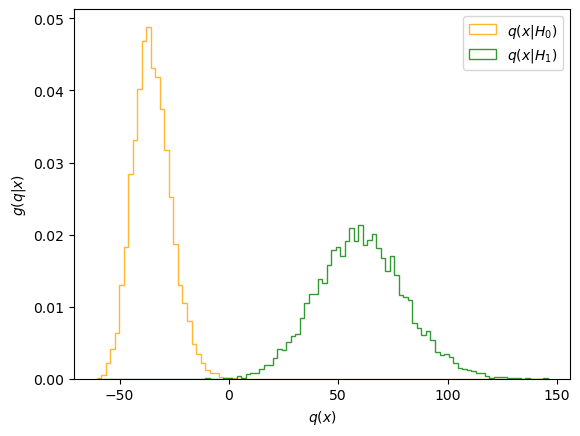

In [2]:
def _llike(rv):
    meths = dir(rv)
    if 'logpdf' in meths: rv.llike = rv.logpdf
    if 'logpmf' in meths: rv.llike = rv.logpmf
    if 'llike' not in dir(rv): print('not llike method')
    return rv.llike

def _xs(vals, ns, size):
    xs = [[vals[i][j] for i in range(ns)] for j in range(size)]
    return xs

def qtest(x, llike0, llike1, par0 = None, par1 = None):
    ll0s = llike0(x) if par0 is None else llike0(x, *par0)
    ll1s = llike1(x) if par1 is None else llike1(x, *par1)
    val = 2*(ll1s - ll0s)
    #print('qtest', val)
    return val

class poisson_ncounter:

    def __init__(self, ss, bs = None, mu = 1.):
        nbins = len(ss)
        bs = bs if bs is not None else np.zeros(nbins)
        self.par     = np.array([mu,])
        self.nbins   = len(ss)
        self.ss      = np.array(ss)
        self.bs      = np.array(bs)

    def _par(self, mu):
        mu = np.array(mu) if mu is not None else self.par
        #print('_mu', mu)
        return mu

    def rvs(self, mu = None, size = 1):
        mu = self._par(mu)
        vals = [stats.poisson.rvs(bi + mu * si, size = size)
                for bi, si in zip(self.bs, self.ss)]
        ns = _xs(vals, self.nbins, size)
        #print('rvs ', ns)
        return ns

    def logpdf(self, x, mu = None):
        mu = self._par(mu)
        pms = [stats.poisson.logpmf(xi, bi + mu * si)
             for bi, si, xi in zip(self.bs, self.ss, x)]
        ll = np.sum(np.array(pms))
        #print('llike ', ll)
        return ll
    
class htsimple:


    def __init__(self, rv0, rv1, size):
        self.rv0  = rv0
        self.rv1  = rv1
        self.size = int(size)
        self.llike0 = _llike(rv0)
        self.llike1 = _llike(rv1)
        x0s = self.rv0.rvs(size = size)
        x1s = self.rv1.rvs(size = size)
        self.x0s = x0s
        self.x1s = x1s
        self.q0s = [self.q(xi) for xi in x0s]
        self.q1s = [self.q(xi) for xi in x1s]
        #print(x0s)
        #print(self.q0s)
        return


    def q(self, x):
        return qtest(x, self.llike0, self.llike1)


    def qrange(self):
        return (np.min(self.q0s), np.max(self.q1s))


    def p0value(self, q):
        nsel = np.sum(self.q0s >= q)
        return 1.*nsel/(1.*len(self.q0s))


    def p1value(self, q):
        nsel = np.sum(self.q1s <= q)
        return 1.*nsel/(1.*len(self.q1s))


    def cls(self, q):
        beta0 = 1.*np.sum(self.q0s <= q)/(1.*len(self.q0s))
        beta1 = 1.*np.sum(self.q1s <= q)/(1.*len(self.q1s))
        return beta1/beta0

def plt_htsimple(hs, x0 = None, nbins = 100):
    q0s, q1s = hs.q0s, hs.q1s
    qrange = hs.qrange()
    c, _ , _ = plt.hist(q0s, nbins, density = True, range = qrange, color = h0color,
             alpha = 0.8, label = r'$q(x|H_0)$', histtype = 'step');
    plt.hist(q1s, nbins, density = True, range = qrange, color = h1color ,
             alpha = 0.8, label = r'$q(x|H_1)$', histtype = 'step');
    if (x0 is not None):
        q0 = hs.q(x0)
        print('q0 ', q0)
        plt.plot((q0, q0), (0., np.max(c)), ls = '-', color = 'black');
        alpha, beta, CLs = hs.p0value(q0), hs.p1value(q0), hs.cls(q0)
        prt_hypotest(x0, alpha, beta, CLs)
    plt.xlabel('$q(x)$'); plt.ylabel('$g(q|x)$')
    plt.legend();
    return

size = 10000

b = np.array([4.0, 2.0, 1.6, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 1.1])

s = np.array([0.2, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0])

x = np.array([4.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0])

h0color, h1color, datacolor = 'orange', 'green', 'black'

h0, h1 = poisson_ncounter(b), poisson_ncounter(b + 10*s)
# test of simple hypothesis - generate events and compute test-statistic
ht  = htsimple(h0, h1, size)
# plot test-statistic distribution (plot x0 if provided as argument)
plt_htsimple(ht, nbins = 100);


- Compute the p-value of $H_0$.

El $p-value$ de la hipótesis $H_{0}$ está relacionado con la significancia, la cual viene dada por:

<h4><center>$\alpha = \int_{k}^{\infty} g(q({\bf x}) | H_0) \mathrm{dx}$</center></h4>

Empleando las funciones descritas en el apartado anterior obtenidas del código proporcionado en los notebooks de la teoría podemos obtener facilmente el q-value y el p0-value.


In [3]:
q = ht.q(x) ; print('q_value = %.2f' % q )


q_value = -33.13


In [4]:
p0 = ht.p0value(q) ; print('p0_value = %.4f' % p0)

p0_value = 0.3913


#### Exercise 1c:
An experiment expects $(2, 1)$ background events in two bins, and a possible signal $(8, 9)$ on top. 
- It observes $(9, 9)$, can we claim an observation?
- In the case it observes $(1, 1)$, can reject the signal at 95 % CL?

#### Resolución


In [13]:
b = [2, 1] ; s = [8, 9] ;x1 = [9, 9]

In [14]:
def two_poisson(b_array, s_array, x_array, size = 10000):
    
    q0s = 0
    q1s = 0
    
    for i in range(len(b_array)):
        
        b = b_array[i]
        s = s_array[i]
        x = x_array[i]
        
        def q(x):
            return 2 *x * (np.log(b+10*s) - np.log(b)) 
    
        # hipothesis
        h0 = stats.poisson(b)
        h1 = stats.poisson(b + s) 

        # m-experiments for both hypothesis
        x0s = h0.rvs(size = int(size))
        x1s = h1.rvs(size = int(size))

        # the q-values for the m-experiments of both hypothesis
        q0s += q(x0s) 
        q1s += q(x1s)

    return q0s, q1s

In [15]:
def q0(b_array, s_array, x_array):
    q0 = 0
    for i in range(len(b_array)):
        
        b = b_array[i]
        s = s_array[i]
        x = x_array[i]
        
        def q(x):
            return 2 *x * (np.log(b+10*s) - np.log(b)) 
    
        q0 += q(x)
    return q0

In [16]:
q0s, q1s = two_poisson(b,s,x1)
q_obs = q0(b,s,x1)

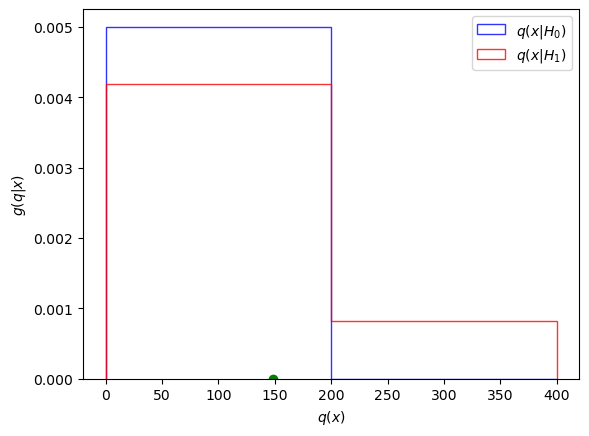

In [17]:
plt_test_stats(q0s, q1s, bins = 2, range = (0, 400));
plt.plot(q0(b,s,x1),0, 'go')

p_value = 0.00000


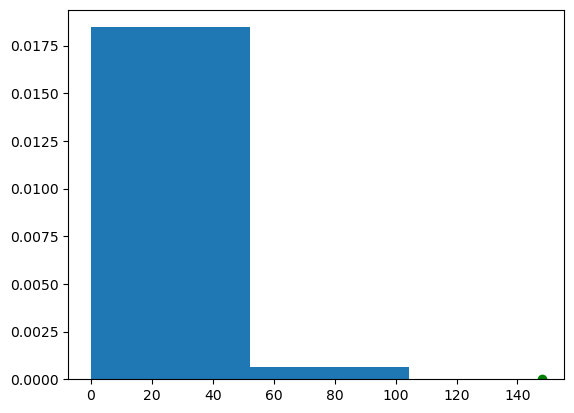

In [18]:
n, bins, patches = plt.hist(q0s, density= True, bins=2)
plt.plot(q0(b,s,x1),0, 'go')
p_value = 0

for i in range(len(n)):
    
    if 0.5*(bins[i+1]+bins[i]) >= q0(b,s,x1):
        
        p_value += n[i]*(bins[i+1] - bins[i])

print('p_value = %.5f' % p_value )

In [19]:
x2 = [1, 1]

In [20]:
q0s, q1s = two_poisson(b,s,x2)
q_obs = q0(b,s,x2)

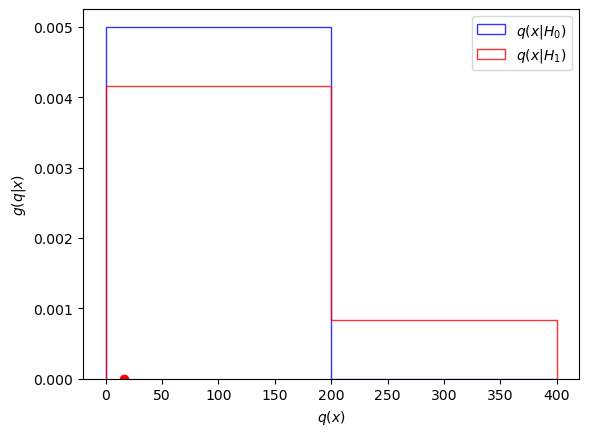

In [21]:
plt_test_stats(q0s, q1s, bins = 2, range = (0, 400));
plt.plot(q0(b,s,x2),0, 'ro')

1.0


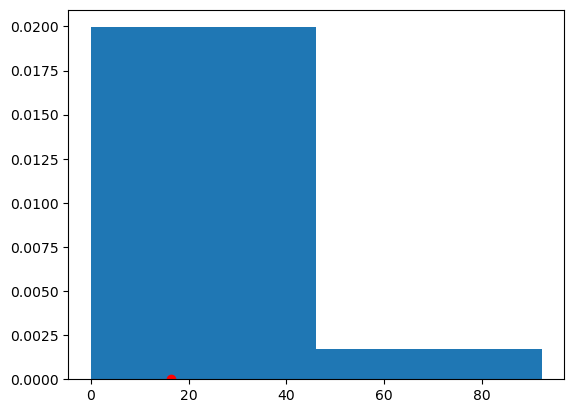

In [22]:
n, bins, patches = plt.hist(q0s, density= True, bins=2)
plt.plot(q0(b,s,x2),0, 'ro')
p_value = 0

for i in range(len(n)):
    
    if 0.5*(bins[i+1]+bins[i]) >= q0(b,s,x2):
        
        p_value += n[i]*(bins[i+1] - bins[i])

print(p_value)

#### Exercise 1d:
Consider now an experiment with several independent channels that expects as background ${\bf b} = (2, 1.5, 1, 0.5)$ and as signal ${\bf s} = (1, 3, 3, 1)$. It measures $(2, 1, 1, 0)$. Compute the p-value of $H_1$.

#### Resolución


q_value = -9.41
p1 = 0.0016


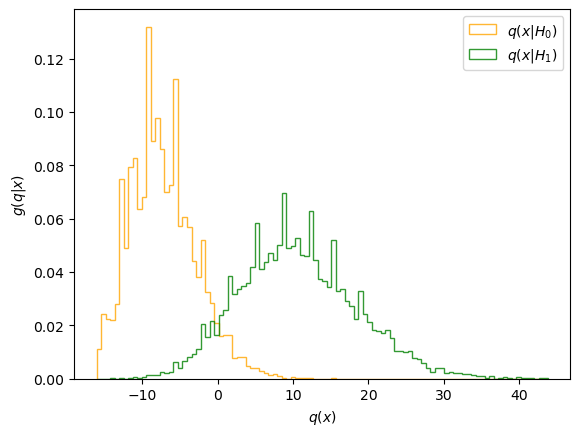

In [13]:
size = 10000

b = np.array([2, 1.5, 1, 0.5])

s = np.array([1, 3, 3, 1])

x = np.array([2, 1, 1, 0])

h0, h1 = poisson_ncounter(b), poisson_ncounter(b + s)
# test of simple hypothesis - generate events and compute test-statistic
ht  = htsimple(h0, h1, size)
# plot test-statistic distribution (plot x0 if provided as argument)
plt_htsimple(ht, nbins = 100)

q = ht.q(x) ; print('q_value = %.2f' % q )

p1 = ht.p1value(q) ; print('p1 = %.4f' % p1)


### Exercises 2: Confidence intervals

#### Exercise 2a: 
Construct the *confident belt* CI at 90% and 68% CL considering a counting experiment with background $b$ and unknown signal $\mu$. In this case, the pdf is a poisson with mean $b + \mu$. We scan along $\mu$ and for each $\mu$ we obtain the interval $[x_l(\mu), x_u(\mu)]$ using the central interval at 90% contaiment. Then, we unify the border of the segments and we define the confident belt.
- What is the CI at 90% CL? And for $b=3$ and $x_0 = 1$?
- Test the coverage of the CI at 90% CL in this example. Consider $b=2$ and $\mu_{true} = 2$.


#### Resolución

Basándonos en lo visto en clase podemos aplicar las siguientes funciones para obtener los intervalos de confianza y el confident belt dados los porcentajes del enunciado. A su ve, usaremos otra función para graficar la banda de confianza de los diferentes intervalos.

In [30]:
def CI(mu, b, beta):

    """
    Esta función nos permite determinar los límites superior e inferior del intervalo de confianza beta para 
    un valor de mu concreto (Necesaria para la segunda parte). Basicamente recorremos las sumas acumulativas de
    las densidades de probabilidad hasta que sean mayores que alpha (para imin) o 1 - alpha (para imax) recogidendo
    los índices que cumplan esta condición y luego nos quedamos con los valores más pequeños, que son los que 
    definirán los intervalos de confianza.
    """
    
    nmax = int(10*(b + mu))                              
    alpha = (1-beta)/2.
    # alpha nos sirve para centrar la banda
    k  = np.array(range(nmax))
    cumul_poisson = np.array([stats.poisson.cdf(i, b + mu) for i in k])
    imins = [i for i in k if cumul_poisson[i] >= alpha]
    imaxs = [i for i in k if cumul_poisson[i] >= 1 - alpha]
    imin, imax = min(imins), min(imaxs)
    
    return imin, imax

In [31]:
def ci_belt(mus, b, beta):
   
    """
    Esta función calcula los valores que definen los límites de la banda de confianza en vals y los devuelve
    (x0s para los imin y x1s para los imax) recorriendo diferentes valores de mu (mu es un array que va desde 0
    hasta un valor mumax). Además, la función xci(x0) devuelve los valores de señal dentro de
    la banda de confianza dada una medida x0.
    
    """
    
    vals = [CI(imu, b, beta) for imu in mus]
    def xci(x):
        sel = [(ixs[0] <= x) & (x <= ixs[1]) for ixs in vals]
        if (sum(sel) <= 1): return None
        _ci = min(mus[sel]), max(mus[sel])
        return _ci
    x0s = np.array([ival[0] for ival in vals])
    x1s = np.array([ival[1] for ival in vals])
    return x0s, x1s, xci

In [32]:
def plt_confbelt(x0, b, beta1 = 0.90, beta2 = 0.68, mumax = 12, musize=200):
    
    """ 
    Esta función realiza una gráfica de la banda de confianza para diferentes intervalos de confianza
    (beta1, beta2)
    
    """
    mus = np.linspace(0., mumax, musize)
    xls, xus, ci1 = ci_belt(mus, b, beta1)
    plt.fill_betweenx(mus, xls, xus, color = 'cyan', label = str(int(100*beta1))+'% CL')
    xls, xus, ci2 = ci_belt(mus, b, beta2)
    plt.fill_betweenx(mus, xls, xus, color = 'blue', label = str(int(100*beta2))+'% CL' )
    plt.plot((x0 + 0.1 , x0 + 0.1), (0, mumax), color = 'black', ls = '--')
    plt.xlabel('$x$')
    plt.ylabel('$\mu$')
    plt.grid()
    plt.legend()
    print('CI ', ci1(x0), ' at ', beta1,'%', 'CL para b = ', b, ' y x0 = ', x0)
    print('CI ', ci2(x0), ' at ', beta2,'%', 'CL para b = ', b, ' y x0 = ', x0)
    return ci1, ci2

Definidas las funciones necesarias veamos los resultados.

CI  (0.0, 1.6884422110552764)  at  0.9 % CL para b =  3  y x0 =  1
CI  (0.0, 0.24120603015075376)  at  0.68 % CL para b =  3  y x0 =  1


(<function __main__.ci_belt.<locals>.xci(x)>,
 <function __main__.ci_belt.<locals>.xci(x)>)

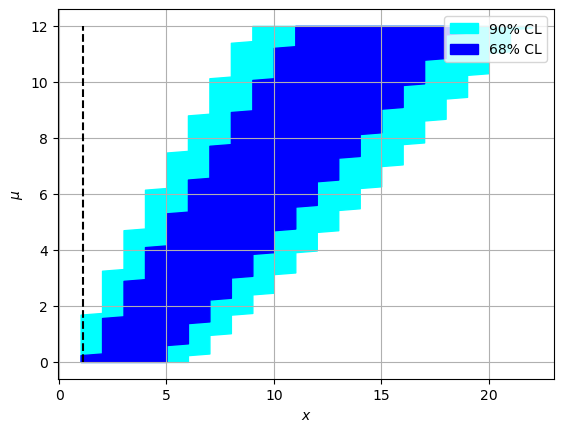

In [33]:
x0, b = 1, 3
plt_confbelt(x0, b, mumax = 12, musize = 200)

- Test the coverage of the CI at 90% CL in this example. Consider $b=2$ and $\mu_{true} = 2$.

In [34]:
print('CI = ', CI(2, 2,0.9))

CI =  (1, 8)


#### Exercise 2c: 
FC is a frequentist method. Verify now that the FC contruction guarantees **coverage** for some examples $b = 3, \mu_{true} = 0.5$


#### Resolución


In [43]:
def CI_fc(mu, b, beta):

    ndim = int(10*(b + mu))

    # range of n-s to study
    ns = np.arange(ndim)
    # probability of n
    ps = np.array([stats.poisson.pmf(ni, b+mu) for ni in ns])
    # best mu estimate for each n
    nhats = np.array([max(0, ni-b) for ni in ns])
    # probability for each n with best estimate of mu
    phs = np.array([stats.poisson.pmf(ni, b+nihat) for ni,nihat in zip(ns, nhats)])
    # the likelihood ratio
    ts = ps/phs

    # compact the values
    zs = list(zip(ts, ps, ns))
    zs.sort()
    zs.reverse()
    ts = np.array([zi[0] for zi in zs])
    ps = np.array([zi[1] for zi in zs])
    ns = np.array([zi[-1] for zi in zs])
    cps = np.array([sum(ps[:i+1]) for i in range(ndim)])
    sel = (cps < beta)
    xbeta = min(cps[~sel])
    sel = (cps <= xbeta)
    iu, il = min(ns[sel]), max(ns[sel])

    result = (iu, il)

    return result

In [44]:
def ci_belt_fc(mus, b, beta):
   
    """
    Esta función calcula los valores que definen los límites de la banda de confianza en vals y los devuelve
    (x0s para los imin y x1s para los imax) recorriendo diferentes valores de mu (mu es un array que va desde 0
    hasta un valor mumax). Además, la función xci(x0) devuelve los valores de señal dentro de
    la banda de confianza dada una medida x0.
    
    """
    
    vals = [CI_fc(imu, b, beta) for imu in mus]
    def xci(x):
        sel = [(ixs[0] <= x) & (x <= ixs[1]) for ixs in vals]
        if (sum(sel) <= 1): return None
        _ci = min(mus[sel]), max(mus[sel])
        return _ci
    x0s = np.array([ival[0] for ival in vals])
    x1s = np.array([ival[1] for ival in vals])
    return x0s, x1s, xci

In [45]:
def plt_confbelt_fc(x0, b, beta1 = 0.90, beta2 = 0.68, mumax = 12, musize=100):
    
    """ 
    Esta función realiza una gráfica de la banda de confianza para diferentes intervalos de confianza
    (beta1, beta2)
    
    """
    mus = np.linspace(0., mumax, musize)
    xls, xus, ci1 = ci_belt_fc(mus, b, beta1)
    plt.fill_betweenx(mus, xls, xus, color = 'red', label = str(int(100*beta1))+'% CL')
    xls, xus, ci2 = ci_belt_fc(mus, b, beta2)
    plt.fill_betweenx(mus, xls, xus, color = 'green', label = str(int(100*beta2))+'% CL' )
    plt.plot((x0 + 0.1 , x0 + 0.1), (0, mumax), color = 'black', ls = '--')
    plt.xlabel('$x$')
    plt.ylabel('$\mu$')
    plt.grid()
    plt.legend()
    print('CI ', ci1(x0), ' at ', beta1,'%', 'CL para b = ', b, ' y x0 = ', x0)
    print('CI ', ci2(x0), ' at ', beta2,'%', 'CL para b = ', b, ' y x0 = ', x0)
    return ci1, ci2

CI  (0.0, 0.9045226130653266)  at  0.9 % CL para b =  3  y x0 =  0
CI  (0.0, 0.06030150753768844)  at  0.68 % CL para b =  3  y x0 =  0


(<function __main__.ci_belt_fc.<locals>.xci(x)>,
 <function __main__.ci_belt_fc.<locals>.xci(x)>)

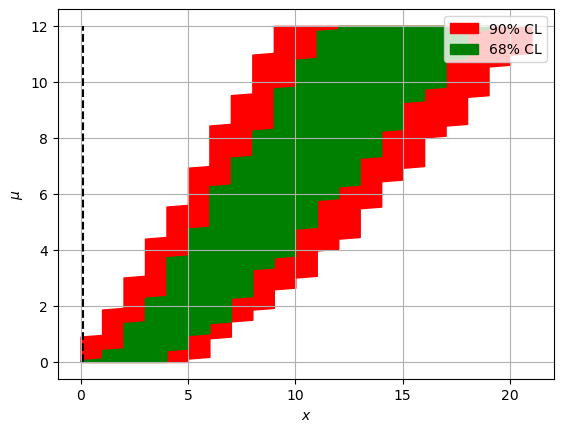

In [46]:
x0, b = 0, 3
plt_confbelt_fc(x0, b, mumax = 12, musize = 200)

In [47]:
b = 3 
mu = 0.5

ci = CI(b, mu, 0.9)
cifc = CI_fc(b, mu, 0.9)

In [48]:
print('ci = ', ci)
print('cifc = ', cifc)

ci =  (1, 7)
cifc =  (1, 6)


#### Exercise 2d: 
Compare the classical and frequentist interval, where they differ? where they are equal? Use the case for example $b=3$.

CI  (0.0, 0.9045226130653266)  at  0.9 % CL para b =  3  y x0 =  0
CI  (0.0, 0.06030150753768844)  at  0.68 % CL para b =  3  y x0 =  0
CI  None  at  0.9 % CL para b =  3  y x0 =  0
CI  None  at  0.68 % CL para b =  3  y x0 =  0


(<function __main__.ci_belt.<locals>.xci(x)>,
 <function __main__.ci_belt.<locals>.xci(x)>)

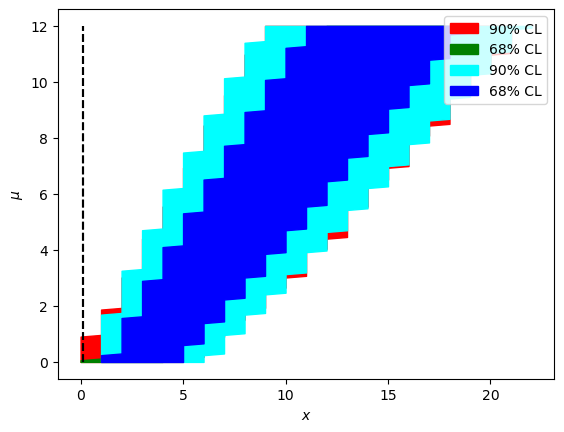

In [49]:
x0, b = 0, 3
plt_confbelt_fc(x0, b, mumax = 12, musize = 200)
plt_confbelt(x0, b, mumax = 12, musize = 200)

#### Vemos que la diferencia fundamental entre los 2 métodos ocurre cuando tenemos pocas observaciones (x). La banda clásica no garantiza un intervalo de confianza mientras que el FC sí. Para el resto de observaciones, ambos son prácticamente idénticos.

### Exercises 3: Hypothesis Case (Composite Case)

#### Exercise 3a: 
Verify that the $q_0$ distribution is a 'half' $\chi^2$.

#### Resolución


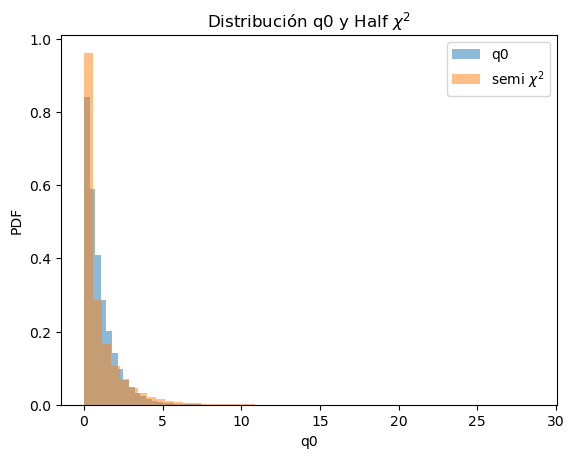

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Parámetros de la distribución chi^2
degrees_of_freedom = 2

# Tamaño de la muestra
sample_size = 10000000

# Genero una muestra de la distribución chi^2
sample_chi2 = np.random.chisquare(degrees_of_freedom, size=sample_size)

# Calculo q0
q0 = sample_chi2 / 2

# Calculamos la PDF de la distribución semi chi^2

pdf_semi_chi2 = np.random.chisquare(degrees_of_freedom/2, size=sample_size)

# Histogramas
plt.hist(q0, bins=50, density=True, alpha=0.5, label='q0')
plt.hist(pdf_semi_chi2, bins=50, density=True, alpha=0.5, label='semi $\chi^2$')

plt.xlabel('q0')
plt.ylabel('PDF')
plt.title('Distribución q0 y Half $\chi^2$')
plt.legend()
plt.show()

#### Exercise 3c:
Consider the case of an experiment that get a sample of n-size poisson disbruted values, $x$, with a unknown mean $\mu$. Check the values of $n$ for whose $g(t_\mu | \mu)$ follows a $\chi^2(1)$ distribution.


#### Resolución


In [112]:
import numpy as np
from scipy.stats import poisson, chi2

# Parámetros de la distribución
mu_values = np.linspace(1,10,10)  # Valores de mu
mu0 = 10  # Hipótesis nula

# Realizar el test para cada valor de mu
for mu in mu_values:
    # Generar una muestra de la distribución de Poisson
    sample = np.random.poisson(mu, size=10000)
    
    # Calcular el estadístico de prueba
    test_statistic = -2 * np.sum(np.log(poisson.pmf(sample, mu0) / poisson.pmf(sample, mu)))
    
    # Calcular el p-valor utilizando la distribución chi-cuadrado
    p_value = chi2.sf(test_statistic, df=1)
    
    # Imprimir resultados
    print(f"mu = {mu}")
    print("Test Statistic: %.3f" % test_statistic)
    print("P-value: %.3f" % p_value)
    print("")
    

mu = 1.0
Test Statistic: 133432.519
P-value: 0.000

mu = 2.0
Test Statistic: 95120.339
P-value: 0.000

mu = 3.0
Test Statistic: 68110.784
P-value: 0.000

mu = 4.0
Test Statistic: 46687.579
P-value: 0.000

mu = 5.0
Test Statistic: 30416.341
P-value: 0.000

mu = 6.0
Test Statistic: 18238.117
P-value: 0.000

mu = 7.0
Test Statistic: 10138.270
P-value: 0.000

mu = 8.0
Test Statistic: 4427.794
P-value: 0.000

mu = 9.0
Test Statistic: 1011.928
P-value: 0.000

mu = 10.0
Test Statistic: -0.000
P-value: 1.000



#### Exercise 3d:
Consider an experiment with a gaussian distribution with mean $\mu$ and sigma 1. Consider $\mu_{true} = \mu_0 = 0$. Obtain the distribution of the upper limits at 90 %CL.


#### Resolución


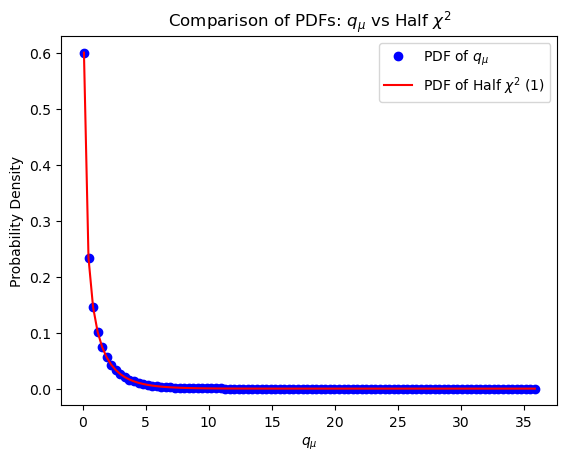

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Parameters
n = 10  # Sample size
mu_true = 3.5  # True mean
sigma = 1.0  # Standard deviation
num_samples = 10000

# Generate random samples from a Gaussian distribution with mean mu_true and standard deviation sigma
samples = np.random.normal(mu_true, sigma, size=(num_samples, n))

# Calculate the test statistic q_mu for each sample
q_mu_values = np.sum(((samples - mu_true) / sigma) ** 2, axis=1)

# Define the range of values for the comparison
x = np.linspace(0.1, np.max(q_mu_values), 100)

# Compute the PDF of q_mu
pdf_q_mu = np.exp(-(x / 2.0)) / (2.0 * np.sqrt(2.0 * np.pi * x))

# Compute the PDF of a "half" chi^2 distribution with one degree of freedom
pdf_half_chi2 = chi2.pdf(x, df=1) / 2.0

# Plot the PDFs of q_mu and "half" chi^2 distribution
plt.plot(x, pdf_q_mu, 'bo',label='PDF of $q_{\mu}$')
plt.plot(x, pdf_half_chi2,'r-', label='PDF of Half $\chi^2$ (1)')
plt.xlabel('$q_{\mu}$')
plt.ylabel('Probability Density')
plt.title('Comparison of PDFs: $q_{\mu}$ vs Half $\chi^2$')
plt.legend()
plt.show()